## Udacity Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of 
* recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Import libraries

In [191]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
from skimage.feature import hog
from cv2 import HOGDescriptor
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label


%matplotlib inline

### Start by reading in all the vehicle and non-vehicle images
* get the images from the 'data2' folder
* label each images to 'car' and 'not car', which is designated by file name
* show the overview of the data distribution

Your function returned a count of 2725  cars and 6267  non-cars
of size:  (64, 64, 3)  and data type: uint8


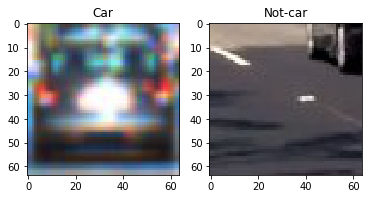

In [530]:
# i used the code from the lessons in Udacity

#images = glob.glob('./dataset/non-vehicles/Extras/*')
#images.extend(glob.glob('./dataset/non-vehicles/GTI/*'))
#images.extend(glob.glob('./dataset/vehicles/GTI_Far/*'))
#images.extend(glob.glob('./dataset/vehicles/GTI_Left/*'))
#images.extend(glob.glob('./dataset/vehicles/GTI_MiddleClose/*'))
#images.extend(glob.glob('./dataset/vehicles/GTI_Right/*'))
#images.extend(glob.glob('./dataset/vehicles/GTI_KITTI_extracted/*'))
images = glob.glob('./data2/*')

cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Not-car')
plt.savefig('./output_images/car_not_car.png')


### Histogram of Oriented Gradients (HOG)

if using hog ....  0.0274 s
if using hog descriptor....  0.0007 s


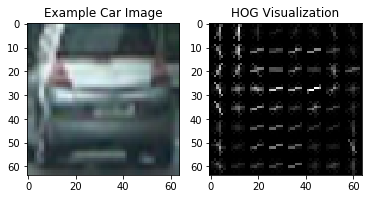

In [612]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False): 
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)

        return features

# Define a function to use HogDescriptor
def get_hogdescriptor_features(img, block_size, stride, pix_per_cell, orient):
    img = (img*256).astype(np.uint8)
    img = cv2.resize(img, (64,64))
    winSize = (img.shape[0], img.shape[1])
    blockSize = (block_size, block_size)
    blockStride = (stride, stride)
    cellSize = (pix_per_cell, pix_per_cell)
    nbins = orient
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    features = hog.compute(img)

    return features


# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Set Parameteer
block_size = 16 # HOG pixels per block
stride =  8 # Block stride
pix_per_cell = 8 # Pixel per cell
cell_per_block = 2 # HOG cells per block
orient = 9  # HOG orientations

# Print the process time
t=time.time()
hog_features = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
t2 = time.time()
print('if using hog .... ', round(t2-t, 4), 's' )
t=time.time()

hogD_features = get_hogdescriptor_features(gray, block_size, stride, pix_per_cell, orient)
hogD_features = np.ravel(hogD_features)
t2 = time.time()
print('if using hog descriptor.... ', round(t2-t, 4), 's')


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('./output_images/HOG_example.jpg')


extract_features ....  13.0539 s


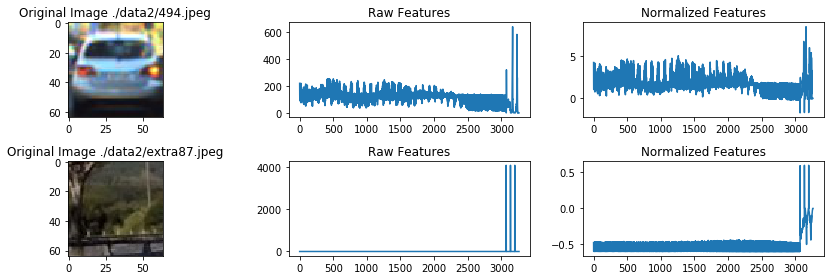

In [534]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space, spatial_size=(32, 32),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_feat=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
        if hog_feat == True:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hogdescriptor_features(feature_image[:,:,channel], block_size, stride, pix_per_cell, orient))
            hog_features = np.ravel(hog_features)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

t=time.time()
car_features = extract_features(cars, color_space='YUV', spatial_size=(32, 32), hist_bins=64)
notcar_features = extract_features(notcars, color_space='YUV', spatial_size=(32, 32), hist_bins=64)
t2 = time.time()
print( 'extract_features .... ', round(t2-t, 4), 's')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    ncar_ind = np.random.randint(0, len(notcars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(231)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image ' + cars[car_ind] )
    plt.subplot(232)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(233)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    plt.subplot(234)
    plt.imshow(mpimg.imread(notcars[ncar_ind]))
    plt.title('Original Image ' + notcars[ncar_ind] )
    plt.subplot(235)
    plt.plot(X[ncar_ind])
    plt.title('Raw Features')
    plt.subplot(236)
    plt.plot(scaled_X[ncar_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Tuning SVM

In [535]:
# performs under different binning scenarios
spatial = 32
histbin = 64

car_features = extract_features(cars, color_space='HLS', spatial_size=(spatial, spatial), hist_bins=histbin)
notcar_features = extract_features(notcars, color_space='HLS', spatial_size=(spatial, spatial), hist_bins=histbin)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#svc = svm.SVC(kernel='linear', C=0.1, decision_function_shape='ovr')
svc = svm.SVC(kernel='rbf', C=10, gamma=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 3264
29.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9928
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  0.  0.  1.]
0.03924 Seconds to predict 10 labels with SVC


In [456]:
# Make Window List
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None: x_start_stop[0] = 0
    if x_start_stop[1] == None: x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None: y_start_stop[0] = 0
    if y_start_stop[1] == None: y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to get features from each flip
# I judged that HLS is best for color features
def single_img_features(img, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_feat=False):    
    # Define an empty list to receive features
    img_features = []
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    img_features.append(spatial_features)
    # Compute histogram features if flag is set
    hist_features = color_hist(feature_image, nbins=hist_bins)
    img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat==True:
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hogdescriptor_features(feature_image[:,:,channel], block_size, stride, pix_per_cell, orient))
        hog_features = np.ravel(hog_features)
        # Append features to list
        img_features.append(hog_features)
    # Return concatenated array of features
    features = np.concatenate(img_features)
    return features


# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_feat=False):
    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for i, window in enumerate(windows):
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
#        else:
#            plt.savefig('./error' + str(i) + '.png')
    # Return windows for positive detections
    return on_windows

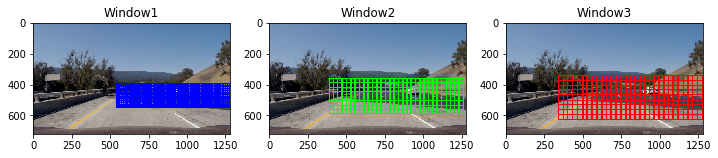

In [602]:
image = mpimg.imread('./test_images/bbox-example-image9.jpg')

window_image = np.copy(image)

test_img = (np.copy(image)/255).astype(np.float32)

windows_s = slide_window(image, (540, 1280), (390, 550), xy_window=(64, 64), xy_overlap=(0.8, 0.8))
windows_m = slide_window(image, (390, 1280), (360, 590), xy_window=(144, 144), xy_overlap=(0.8, 0.8))
windows_l = slide_window(image, (340, 1280), (340, 640), xy_window=(160, 160), xy_overlap=(0.8, 0.8))

window_image1 = draw_boxes(window_image, windows_s, color=(0, 0, 255), thick=6)
window_image2 = draw_boxes(window_image, windows_m, color=(0, 255, 0), thick=6)
window_image3 = draw_boxes(window_image, windows_l, color=(255, 0, 0), thick=6)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(window_image1)
plt.title('Window1')
plt.subplot(132)
plt.imshow(window_image2)
plt.title('Window2')
plt.subplot(133)
plt.imshow(window_image3)
plt.title('Window3')

7


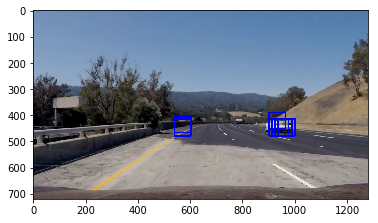

In [603]:
# Set Parameteer
block_size = 16 # HOG pixels per block
stride = 8 # Block stride
pix_per_cell = 8 # Pixel per cell
cell_per_block = 2 # HOG cells per block
orient = 9  # HOG orientations
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins

image = mpimg.imread('./test_images/bbox-example-image9.jpg')

window_image = np.copy(image)

#test_img = (np.copy(image)/255).astype(np.float32)
test_img = np.copy(image)

box_list = []
test_s_size = search_windows(test_img, windows_s, svc, X_scaler, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
box_list.extend(test_s_size)
test_m_size = search_windows(test_img, windows_m, svc, X_scaler, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
box_list.extend(test_m_size)
test_l_size = search_windows(test_img, windows_l, svc, X_scaler, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
box_list.extend(test_l_size)

window_image = draw_boxes(window_image, box_list, color=(0, 0, 255), thick=6)

print(len(box_list))
plt.imshow(window_image)

In [557]:
# performs under different binning scenarios
spatial = 32
histbin = 64
block_size = 16 # HOG pixels per block
stride =  8 # Block stride
pix_per_cell = 8 # Pixel per cell
cell_per_block = 2 # HOG cells per block
orient = 9  # HOG orientations



car_features = extract_features(cars, color_space='HLS', spatial_size=(spatial, spatial), hist_bins=histbin, hog_feat=True)
notcar_features = extract_features(notcars, color_space='HLS', spatial_size=(spatial, spatial), hist_bins=histbin, hog_feat=True)

# Create an array stack of feature vectors
X2 = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler2 = StandardScaler().fit(X2)
# Apply the scaler to X
scaled_X2 = X_scaler2.transform(X2)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train2, X_test2, y_train, y_test = train_test_split(scaled_X2, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train2[0]))
# Use a linear SVC 
svc2 = svm.SVC(kernel='rbf', C=10, gamma = 'auto')
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train2, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc2.score(X_test2, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc2.predict(X_test2[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 8556
106.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9989
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  0.  0.  1.  0.]
0.14115 Seconds to predict 10 labels with SVC


10


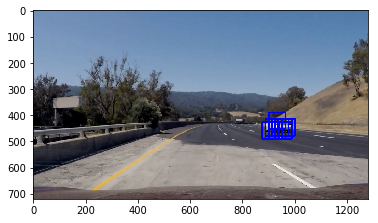

In [604]:
test_img = mpimg.imread('./test_images/bbox-example-image9.jpg')

window_image = np.copy(test_img)
box_list =[]
box_list = search_windows(test_img, windows_s, svc2, X_scaler2, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_feat=True)
box_list.extend(search_windows(test_img, windows_m, svc2, X_scaler2, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_feat=True))
box_list.extend(search_windows(test_img, windows_l, svc2, X_scaler2, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_feat=True))
window_image = draw_boxes(test_img, box_list, color=(0, 0, 255), thick=6)

print(len(box_list))
plt.imshow(window_image)

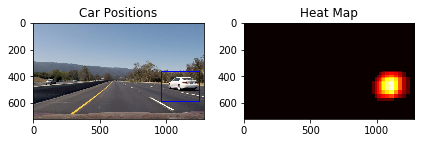

In [560]:

# Read in image similar to one shown above 
image = mpimg.imread('./test_images/bbox-example-image8.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()





### Video

In [521]:
class Box():
    def __init__(self):
        # was the line detected in the last iteration?
        self.count = 0
        self.list = []

In [613]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
image = np.zeros_like(image)

box = Box()
def video_pipeline(img):
    if box.count == 0:
        #test_img = (np.copy(img)/255).astype(np.float32)
        box_list = []
        box_list = search_windows(img, windows_s, svc2, X_scaler2, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_feat=True)
        box_list.extend(search_windows(img, windows_m, svc2, X_scaler2, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_feat=True))
        box_list.extend(search_windows(img, windows_l, svc2, X_scaler2, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_feat=True))

        
        # Add heat to each box in box list
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,8)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        window_image = draw_labeled_bboxes(np.copy(img), labels)
        box.list = labels
        box.count += 1
    
    else:
        window_image = draw_labeled_bboxes(np.copy(img), box.list)
        box.count +=1
        if box.count == 15:
            box.count = 0
    
    return window_image

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './output_images/project_video_result.mp4'
clip1 = VideoFileClip('./project_video.mp4')

white_clip = clip1.fl_image(video_pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video ./output_images/project_video_result.mp4
[MoviePy] Writing video ./output_images/project_video_result.mp4


 10%|▉         | 123/1261 [01:41<29:33,  1.56s/it]

### Parameter Tuning by using GridSearch

In [365]:
parameters = {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}


In [372]:
parameters = {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train2, y_train)

print(clf.best_params_)

{'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}


In [454]:
parameters = {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
